In [4]:
import pandas as pd
import numpy as np
import os
import glob
import geopandas as gpd
import xarray as xr
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

In [5]:
root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

Import the data into a standard structrue for the geopandas dataframes

In [3]:
def Import_Points(infile, inputs):
    #print(inputs["Type"])
    #Get the before and after columns names
    usecols = list(filter(None,list(inputs.values())[1:8]))
    col_names = list({key: value for key, value in inputs.items() if value in usecols}.keys())
    
    #Get the data types
    t_dtypes = {key: value for key, value in dtypes.items() if key in col_names}
    dtypes_in = {inputs[k]:v for k, v in t_dtypes.items()}
    dtype_out = {key: value for key, value in dtypes.items() if key in col_names}

    #Import the data
    df = pd.read_csv(infile, usecols=usecols, encoding = "ISO-8859-1", dtype=dtypes_in) 

    #Reformat ready for next step
    df.columns = col_names
    df = df.astype(dtype_out)

    df["Type"] = inputs["Type"]
    return df

In [4]:
#source data
rail_infile = root_path + "NaPTANcsv/RailReferences.csv"
rail_inputs = {"Type":"RailwayStations", "Name":"StationName", "Easting":"Easting", "Northing":"Northing"}

ferry_infile = root_path + "NaPTANcsv/FerryReferences.csv"
ferry_inputs = {"Type":"FerryTerminals", "Name":"Name", "Easting":"Easting", "Northing":"Northing"}

bus_infile = root_path + "NaPTANcsv/Stops.csv"
bus_inputs = {"Type":"BusStops", "Name":"CommonName", "Easting":"Easting", "Northing":"Northing"}

acc2020_infile = root_path + "RoadSafety/dft-road-casualty-statistics-accident-2020.csv"
acc2020_inputs = {"Type":"RoadAccidents", "Name":"accident_reference", "Easting":"location_easting_osgr", "Northing":"location_northing_osgr"}

NSPL_infile = root_path + "NSPL_NOV_2020_UK/Data/NSPL_NOV_2020_UK.csv"
NSPL_inputs = {"Type":"Postcodes", "Name":"pcd", "Easting":"oseast1m", "Northing":"osnrth1m"}

#NSUL_Infile defined below
NSUL_inputs = {"Type":"UDPRNs", "Name":"uprn", "Easting":"gridgb1e", "Northing":"gridgb1n", "Details_Str":"pcds"}

point_pairs = [[rail_infile, rail_inputs],
[ferry_infile, ferry_inputs],
[bus_infile, bus_inputs],
[acc2020_infile, acc2020_inputs],
[NSPL_infile,NSPL_inputs]]

NSUL_Pairs = [[root_path + "NSUL_OCT_2020/Data/" + str(i), NSUL_inputs] for i in os.listdir("D:/GeoData/NSUL_OCT_2020/Data") if ".csv" in i]

point_pairs = point_pairs + NSUL_Pairs


In [5]:
#initiate the standard structure
Points_of_Interest = pd.DataFrame({"Type":"", "Name":"", "Details_Str":"", "Details_Float":0, "Easting":0, "Northing":0}, index=[0])
dtypes = {"Type":"str", "Name":"str", "Details_Str":"str", "Details_Float":np.float64, "Easting":np.float64, "Northing":np.float64}
Points_of_Interest = Points_of_Interest.astype(dtypes)
Points_of_Interest = Points_of_Interest.drop(0)

In [6]:
for l in point_pairs:
    Points_of_Interest = Points_of_Interest.append(Import_Points(l[0], l[1]), ignore_index=True)

#remove the spaces from the postcode
Points_of_Interest.loc[Points_of_Interest["Type"]=="Postcodes", "Name"] = Points_of_Interest.loc[Points_of_Interest["Type"]=="Postcodes", "Name"].astype(str).str.replace(" ","")


In [7]:
#Import the land registry data, merge on the postcodes from NSPL data then add to the main file
LReg_Names = ['Transaction_unique_identifier', 'Price', 'Date_of_Transfer', 'Postcode', 'Property_Type', 
              'Old_New', 'Duration', 'PAON', 'SAON', 'Street', 'Locality', 'Town_City', 'District', 'County', 
              'PPDCategory_Type', 'Record_Status_monthly_file_only']

usecols = ['Transaction_unique_identifier', 'Price', 'Date_of_Transfer', 'Postcode', 'Property_Type', 'Old_New', 'Duration']

LReg_Data2020 = pd.read_csv(root_path + "LandReg/pp-2020.csv", names=LReg_Names, usecols=usecols) 
LReg_Data2021 = pd.read_csv(root_path + "LandReg/pp-2021.csv", names=LReg_Names, usecols=usecols)

LReg_Data = pd.concat([LReg_Data2020, LReg_Data2021])

#remove the spaces from the postcode
LReg_Data["Postcode"] = LReg_Data["Postcode"].astype(str).str.replace(" ","")

LReg_Data = LReg_Data.merge(Points_of_Interest.loc[Points_of_Interest["Type"]=="Postcodes", ["Name", "Easting", "Northing"]], left_on="Postcode", right_on="Name")

LReg_Data["Details_Str"] = np.column_stack((LReg_Data["Date_of_Transfer"].to_numpy(),
    LReg_Data["Property_Type"].to_numpy(), 
    LReg_Data["Old_New"].to_numpy(), 
    LReg_Data["Duration"].to_numpy())
    ).tolist()

LReg_Data["Details_Float"] = LReg_Data["Price"]
LReg_Data["Name"] = LReg_Data["Transaction_unique_identifier"]
LReg_Data["Type"] = "LReg"
LReg_Data = LReg_Data.loc[:, ["Type", "Name", "Details_Str", "Details_Float", "Easting", "Northing"]]

Points_of_Interest = Points_of_Interest.append(LReg_Data, ignore_index=True)
del LReg_Data, LReg_Data2020, LReg_Data2021, LReg_Names, usecols

In [8]:
#Firestation Data
FireStations = pd.read_excel(root_path + "Fire_data/" + "fire-stations-dataset-121120.ods", 
                         engine="odf",
                        sheet_name = "STATIONS")

FireStations["Type"] = "FireStations"
FireStations["Name"] = FireStations["STATION_NAME"]
FireStations["Easting"] = FireStations["STATION_EASTING"]
FireStations["Northing"] = FireStations["STATION_NORTHING"]
FireStations = FireStations.loc[:, ["Type", "Name", "Easting", "Northing"]]

Points_of_Interest = Points_of_Interest.append(FireStations, ignore_index=True)
del FireStations

In [9]:
#Schools Data
usecols=["Postcode", "EstablishmentName", "EstablishmentTypeGroup (name)"]
Schools =pd.read_csv(root_path+"Schools/"+"results.csv", encoding = "ISO-8859-1", low_memory=False, usecols=usecols)

#remove the spaces from the postcode
Schools["Postcode"] = Schools["Postcode"].astype(str).str.replace(" ","")

Schools = Schools.merge(Points_of_Interest.loc[Points_of_Interest["Type"]=="Postcodes", ["Name", "Easting", "Northing"]], left_on="Postcode", right_on="Name")

Schools["Type"] = "Schools"
Schools["Details_Str"] = Schools["EstablishmentTypeGroup (name)"]
Schools["Name"] = Schools["EstablishmentName"]
Schools = Schools.loc[:, ["Type", "Name", "Details_Str","Easting", "Northing"]]

Points_of_Interest = Points_of_Interest.append(Schools, ignore_index=True)
del Schools, usecols

In [10]:
#Computer doesn't have enough ram to deal with UDPRN data so need to drop it here
Points_of_Interest = Points_of_Interest[Points_of_Interest["Type"]!="UDPRNs"]

In [11]:
#We know that some of the easings and northings are on the Irish grid, split these out
NI_Mask_1 = ((Points_of_Interest["Type"]=="Postcodes") & (Points_of_Interest["Name"].str.slice(stop=2)=="BT")).to_numpy()
NI_Mask_2 =  ((Points_of_Interest["Type"]=="UDPRNs") & (Points_of_Interest["Details_Str"].str.slice(stop=2)=="BT")).to_numpy()
NI_Mask = np.logical_or(NI_Mask_1, NI_Mask_2)

NI = Points_of_Interest.loc[NI_Mask,:]
Points_of_Interest = Points_of_Interest.loc[~NI_Mask,:]

del NI_Mask_1, NI_Mask_2, NI_Mask

In [12]:
#Convert to Geopandas dataframe
x_points = Points_of_Interest["Easting"].to_numpy()
y_points = Points_of_Interest["Northing"].to_numpy()

raw_gdf = gpd.GeoDataFrame(Points_of_Interest.loc[:,["Type", "Name", "Details_Str", "Details_Float"]], geometry=gpd.points_from_xy(x_points, y_points), crs=Main_CRS)
del Points_of_Interest, x_points, y_points

#Do the same for NI, and convert to the appropriate crs
x_points = NI["Easting"].to_numpy()
y_points = NI["Northing"].to_numpy()

NI_gdf = gpd.GeoDataFrame(NI.loc[:,["Type", "Name", "Details_Str", "Details_Float"]], geometry=gpd.points_from_xy(x_points, y_points), crs="EPSG:29902")
NI_gdf = NI_gdf.to_crs(Main_CRS)
del NI, x_points, y_points

#Re-combine now they are on the same coordinates
raw_gdf = gpd.GeoDataFrame( pd.concat( [raw_gdf, NI_gdf], ignore_index=True) )
del NI_gdf

<AxesSubplot:>

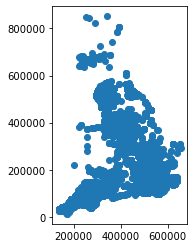

In [7]:
#Police Crime data
usecols = ["Crime type", "Month", "Longitude", "Latitude"]
in_dtypes = {"Crime type":"str", "Longitude":np.float64, "Latitude":np.float64, "Month":"str"}

file_list = []
for root, dirs, files in os.walk("D:/GeoData/PoliceData/"):
    for name in files:
        if name.endswith(("street.csv")):
            file_list = file_list + [str(root) + "/" + str(name)]

infile = file_list[0]

Crimes = pd.read_csv(infile, encoding = "ISO-8859-1", dtype=in_dtypes, usecols=usecols)

for file in file_list[1:]:
    Crimes=Crimes.append(pd.read_csv(file, encoding = "ISO-8859-1", dtype=in_dtypes, usecols=usecols), ignore_index=True)

Crimes = Crimes.dropna()
Crimes = Crimes.rename(columns={"Crime type": "Name"})
Crimes = Crimes.rename(columns={"Month": "Details_Str"})
Crimes["Type"] = "Crimes"

#Police Stop and Search Data
usecols = ["Object of search", "Date", "Longitude", "Latitude"]
in_dtypes = {"Object of search":"str", "Longitude":np.float64, "Latitude":np.float64}

file_list = []
for root, dirs, files in os.walk("D:/GeoData/PoliceData/"):
    for name in files:
        if name.endswith(("search.csv")):
            file_list = file_list + [str(root) + "/" + str(name)]

infile = file_list[0]

StopAndSearch = pd.read_csv(infile, encoding = "ISO-8859-1", dtype=in_dtypes, usecols=usecols, parse_dates=["Date"])

for file in file_list[1:]:
    StopAndSearch=StopAndSearch.append(pd.read_csv(file, encoding = "ISO-8859-1", dtype=in_dtypes, usecols=usecols, parse_dates=["Date"]), ignore_index=True)

StopAndSearch = StopAndSearch.dropna()
StopAndSearch = StopAndSearch.rename(columns={"Object of search": "Name"})
StopAndSearch["Date"] = StopAndSearch["Date"].dt.strftime('%Y-%m-%d')
StopAndSearch = StopAndSearch.rename(columns={"Date": "Details_Str"})
StopAndSearch["Type"] = "StopAndSearch"

Crimes = Crimes.append(StopAndSearch,ignore_index=True)
del StopAndSearch

#Convert to Geopandas dataframe
x_points = Crimes["Longitude"].to_numpy()
y_points = Crimes["Latitude"].to_numpy()

crimes_gdf = gpd.GeoDataFrame(Crimes.loc[:,["Type", "Name", "Details_Str"]], geometry=gpd.points_from_xy(x_points, y_points), crs="EPSG:4326")
crimes_gdf = crimes_gdf.to_crs(Main_CRS)
crimes_gdf

del Crimes

#combine with the main points gdf
raw_gdf = gpd.GeoDataFrame( pd.concat( [raw_gdf, crimes_gdf], ignore_index=True) )
del crimes_gdf, file_list, infile, usecols, in_dtypes



In [14]:
#NHS Data

usecols = ["OrganisationType", "OrganisationName", "Longitude", "Latitude"]
in_dtypes = {"OrganisationType":"str", "OrganisationName":"str", "Longitude":np.float64, "Latitude":np.float64}

NHS_list = [root_path + "NHS/" + str(i) for i in os.listdir("D:/GeoData/NHS") if ".csv" in i]

NHS = pd.read_csv(NHS_list[0], sep='¬'  , engine='python', encoding = "ISO-8859-1", usecols=usecols, dtype=in_dtypes)

for file in NHS_list[1:]:
    NHS = NHS.append(pd.read_csv(file, sep='¬'  , engine='python', encoding = "ISO-8859-1", usecols=usecols, dtype=in_dtypes), ignore_index=True)

NHS = NHS.rename(columns={"OrganisationType":"Type", "OrganisationName":"Name"})

#Convert to Geopandas dataframe
x_points = NHS["Longitude"].to_numpy()
y_points = NHS["Latitude"].to_numpy()

NHS_gdf = gpd.GeoDataFrame(NHS.loc[:,["Type", "Name"]], geometry=gpd.points_from_xy(x_points, y_points), crs="EPSG:4326")
NHS_gdf = NHS_gdf.to_crs(Main_CRS)
NHS_gdf

del NHS

raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, NHS_gdf], ignore_index=True) )

del NHS_gdf, usecols, in_dtypes, NHS_list

In [15]:
Shape_Loc = {
    'All_GB' : [root_path + "Countries__December_2019__Boundaries_UK_BFC-shp/Countries__December_2019__Boundaries_UK_BFC.shp", "ctry19nm"],
    'National_Parks' : [root_path + "National_Parks__December_2019__GB_BFE-shp/National_Parks__December_2019__GB_BFE.shp", "NPARK19NM"],
    'LocalAuthorities' : [root_path + "Local_Authority_Districts__May_2020__Boundaries_UK_BFC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BFC.shp", "LAD20NM"],
    'LSOA' : [root_path + "Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2-shp/Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2.shp", "LSOA11NMW"],
    'GreenSpace' : [root_path + "opgrsp_essh_gb/OS Open Greenspace (ESRI Shape File) GB/data/GB_GreenspaceSite.shp", "id"],
    'Rivers' : [root_path + "oprvrs_essh_gb/data/WatercourseLink.shp","name1"],
    'Railway_Lines' : [root_path + "strtgi_essh_gb/data/railway_line.shp","LEGEND"],
    'Woodland_Region' : [root_path + "strtgi_essh_gb/data/woodland_region.shp","LEGEND"],
    'Urban_Region' : [root_path + "strtgi_essh_gb/data/urban_region.shp","LEGEND"],
    'Foreshor_Region' : [root_path + "strtgi_essh_gb/data/foreshor_region.shp","LEGEND"],
    'Ferry_Line' : [root_path + "strtgi_essh_gb/data/ferry_line.shp","LEGEND", ["FERRY_TIME", "FERRY_TYPE", "RESTRICTIO", "ACCESS"]],
    'Coastline' : [root_path + "strtgi_essh_gb/data/coastline.shp","LEGEND"],
    'Lakes' : [root_path + "strtgi_essh_gb/data/lakes_region.shp", "LEGEND"]}

In [16]:
def getextra(list):
    try:
        extra = list[2]
        extraexists = True
    except:
        extra = []
        extraexists = False

    return extra, extraexists

def get_shapefile(v):
    extra, extraexists = getextra(v)
    gdf = gpd.read_file(v[0]).to_crs(Main_CRS).loc[:,[v[1], "geometry"]+extra]
    gdf = gdf.rename(columns={v[1]: "Name"})
    gdf["Type"] = k

    usecols = ["Type", "Name", "geometry"]

    if extraexists:
        array = gdf[extra[0]].to_numpy()
        if len(extra)>1:
            for e in extra[1:]:
                array = np.column_stack((array,gdf[e].to_numpy()))
        gdf["Details_Str"] = array.tolist()
        usecols = usecols + ["Details_Str"]

    gdf = gdf[usecols]

    return gdf

In [17]:
#Add all of the shape files to the master list

for k in Shape_Loc.keys():
    v = Shape_Loc[k]
    raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, get_shapefile(v)], ignore_index=True) )

del Shape_Loc

In [18]:
#add the roads
file = os.listdir("D:\GeoData\oproad_essh_gb\data")
ignore_cols = ["fictitious", "identifier", "name1_lang", "name2", "name2_lang", "formOfWay", "length", "primary", "trunkRoad", "loop", "startNode", "endNode", "structure", "nameTOID", "numberTOID", "function"]

path = [os.path.join("D:\GeoData\oproad_essh_gb\data", i) for i in file if "RoadLink.shp" in i]

Roads = gpd.GeoDataFrame(pd.concat([gpd.read_file(i, ignore_fields=ignore_cols) for i in path], ignore_index=True), crs=Main_CRS)

Roads["Type"] = "Road"
Roads = Roads.rename(columns={"class": "Name"})
Roads = Roads.rename(columns={"roadNumber": "Details_Str"})
Roads.loc[Roads["Details_Str"].isnull(),"Details_Str"] = Roads["name1"]
Roads = Roads.drop(columns=["name1"])

raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, Roads], ignore_index=True) )
del Roads, ignore_cols, path

#Add the motorway junctions
path = [os.path.join("D:\GeoData\oproad_essh_gb\data", i) for i in file if "MotorwayJunction.shp" in i]

MotorwayJunctions = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path],  ignore_index=True), crs=Main_CRS)

MotorwayJunctions = MotorwayJunctions.drop(columns="identifier")
MotorwayJunctions = MotorwayJunctions.rename(columns={"number": "Name"})
MotorwayJunctions["Type"] = "MotorwayJunction"

raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, MotorwayJunctions], ignore_index=True) )
del MotorwayJunctions, path, file


In [19]:
#Natural England data
NE_Data = {
    "NE_Peat" : {"url":"https://opendata.arcgis.com/datasets/55b21c31a61c4292a465d7618d831eb8_0.geojson", "Type":"Peat", "Name":"PCLASSDESC", "Details_Str":"Type", "geometry":"geometry"},
    "NE_SSI" : {"url":"https://opendata.arcgis.com/datasets/03fd7a2f8e4e4346bf41ce7879153949_0.geojson", "Type":"SiteOfScientificInterest", "Name":"SSSI_NAME", "Details_Str":"OBJECTID", "geometry":"geometry"},
    "NE_LocalNatureReserve" : {"url":"https://opendata.arcgis.com/datasets/b1d690ac6dd54c15bdd2d341b686ecd7_0.geojson", "Type":"LocalNatureReserve", "Name":"LNR_NAME", "Details_Str":"OBJECTID", "geometry":"geometry"},
    "NE_NationalNatureReserve" : {"url":"https://opendata.arcgis.com/datasets/ab7bfd86f5b347df8d47fc9bfab80caf_0.geojson", "Type":"NationalNatureReserve", "Name":"NNR_NAME", "Details_Str":"OBJECTID", "geometry":"geometry"},
    "NE_SpecialAreaOfConvervation" : {"url":"https://opendata.arcgis.com/datasets/e4142658906c498fa37f0a20d3fdfcff_0.geojson", "Type":"SpecialAreaOfConservation", "Name":"SAC_NAME", "Details_Str":"SAC_CODE", "geometry":"geometry"},
    "NE_AncientWoodland" : {"url":"https://opendata.arcgis.com/datasets/a14064ca50e242c4a92d020764a6d9df_0.geojson", "Type":"AncientWoodland", "Name":"NAME", "Details_Str":"THEMNAME", "geometry":"geometry"}
}

def get_NE_Data(details):
    url = details["url"]

    usecols = [details["Name"], details["Details_Str"], details["geometry"]]

    gdf = gpd.read_file(url).to_crs(Main_CRS).loc[:, usecols]


    gdf = gdf.rename(columns={details["Name"]: "Name"})
    gdf = gdf.rename(columns={details["Details_Str"]: "Details_Str"})
    gdf = gdf.rename(columns={details["geometry"]: "geometry"})
    gdf["Type"] = details["Type"]

    return gdf

for k in NE_Data.keys():
    v = NE_Data[k]
    raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, get_NE_Data(v)], ignore_index=True) )

del NE_Data

In [20]:
#Historic England Data
 
path = root_path + "HistoricEngland/Conservation Areas/20210922_Conservation_Areas_INSPIRE_dataset.shp"
HE_gdf = gpd.read_file(path).loc[:,["NAME", "geometry"]].to_crs(Main_CRS)
HE_gdf = HE_gdf.rename(columns={"NAME": "Name"})
HE_gdf["Type"] = "ConservationArea"

path = root_path + "HistoricEngland/Listed Buildings/ListedBuildings_12Jan2022.shp"
LB_gdf = gpd.read_file(path).loc[:,["Name", "Grade", "geometry"]].to_crs(Main_CRS)
LB_gdf = LB_gdf.rename(columns={"Grade": "Details_Str"})
LB_gdf["Type"] = "Listed Buildings"

HE_gdf = gpd.GeoDataFrame(pd.concat( [HE_gdf, LB_gdf], ignore_index=True) )
del LB_gdf

raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, HE_gdf], ignore_index=True) )
del HE_gdf, path

In [21]:
#Met office data for 2020
met_data = {
    "rainfall":["MetOffice/rainfall_hadukgrid_uk_1km_ann_202001-202012.nc", "TotalRainfall_mm_2020"],
    "snowLying":["MetOffice/snowLying_hadukgrid_uk_1km_ann_202001-202012.nc", "Snow_Days_2020"],
    "sun":["MetOffice/sun_hadukgrid_uk_1km_ann_202001-202012.nc", "Sunlight_h_2020"],
    "tas":["MetOffice/tas_hadukgrid_uk_1km_ann_202001-202012.nc", "AverageTemperature_C_2020"],
    "groundfrost":["MetOffice/groundfrost_hadukgrid_uk_1km_ann_202001-202012.nc", "GroundFrost_Days_2020"]
    }

def import_met(path, col, name):
    pth = root_path +path
    dnc = xr.open_dataset(pth)  
    df = dnc.to_dataframe()

    df = df.dropna().reset_index().loc[:, ["projection_y_coordinate", "projection_x_coordinate", col, "bnds"]]
    df = df.loc[df["bnds"]==0,:].drop(columns="bnds").reset_index(drop=True)
    df = df.rename(columns={col: "Details_Float"})
    df["Name"] = name
    df["Type"] = "MetOffice"

    #Convert to Geopandas dataframe
    x_points = df["projection_x_coordinate"].to_numpy()
    y_points = df["projection_y_coordinate"].to_numpy()

    gdf = gpd.GeoDataFrame(df.loc[:,["Details_Float", "Type", "Name"]], geometry=gpd.points_from_xy(x_points, y_points), crs=Main_CRS)

    return gdf

for k in met_data.keys():
    raw_gdf = gpd.GeoDataFrame(pd.concat( [raw_gdf, import_met(met_data[k][0], k, met_data[k][1])], ignore_index=True) )

del met_data

In [22]:
#Remove invalid geometeries
raw_gdf = raw_gdf[raw_gdf.is_valid]

In [ ]:
raw_gdf.to_pickle(root_path + 'WorkingData/' + 'raw_gdf.pkl')

In [ ]:
def MakePolygon(centre, sq_sz, inp_crs):
    mnx = centre[0]-(sq_sz/2)
    mny = centre[1]-(sq_sz/2)
    mxx = centre[0]+(sq_sz/2)
    mxy = centre[1]+(sq_sz/2)
    polygon =Polygon([(mnx, mny), (mnx,mxy), (mxx,mxy), (mxx,mny), (mnx, mny)])
    poly_gdf = gpd.GeoDataFrame(geometry=[polygon], crs=inp_crs)
    return poly_gdf

In [ ]:
def simple_clip(name):
    poly = MakePolygon(KeyLocations[name], 5000, Main_CRS)
    simple = gpd.clip(raw_gdf, poly)
    simple.to_pickle(root_path + 'WorkingData/' + 'raw_gdf_' + name + '.pkl')

In [ ]:
KeyLocations = {'Grasmere': [334692 , 506545],
    'South_London' : [535493, 171250],
    'Loch_Lomond' : [238450 , 690986],
    'Furness' : [326877 , 474372],
    'Croydon' : [532621 , 165313],
    'StPauls' : [532052 , 181145],
    'M25' : [503078 , 178200],
    'M4_junct' : [519377 , 178360],
    'M6_Junctions' : [357659 , 425462],
    'Kendal': [353086 , 492882],
    'Milford Haven': [190649 , 205747],
    'Birmingham':[409295 , 290319],
    'Euston':[529947 , 182697],
    'Southampton':[441934 , 111013],
    'Windermere': [341217 , 498029],
    'Avonmouth': [351730 , 178243]
    }

In [ ]:
for k in KeyLocations.keys():
    simple_clip(k)

In [ ]:
raw_gdf["Type"].dropna().unique().tolist()